In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

Here, we load the serialized DataFrame saved in step 1.

In [2]:
raw_input = pd.read_pickle('sample.pkl')

In [3]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit
546702,558652,90,1,"Dear Madam, How are you? This is Dave from Chi...",1,Introducing yourself by email,1
404822,413388,83,1,Hello! My name's Giller. I'm from Brazil and a...,1,Introducing yourself by email,1
923318,946256,100,1,"Good evening. How are you? I'm fine, thanks. W...",1,Introducing yourself by email,1
769679,788653,95,1,"Good evening. How are you? I'm fine , thanks. ...",1,Introducing yourself by email,1
614952,629221,95,1,"Dear Ms Thomas, There are thirteen computers a...",2,Taking inventory in the office,2


In [4]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 546702 to 844382
Data columns (total 7 columns):
article_id    16000 non-null int64
grade         16000 non-null int64
level         16000 non-null int64
text          16000 non-null object
topic_id      16000 non-null int64
topic_text    16000 non-null object
unit          16000 non-null int64
dtypes: int64(5), object(2)
memory usage: 1000.0+ KB


# Convert Text to Vector Space Representation

Now we convert each document as a vector of tf-idf features. Then we apply Non-negative Matrix Factorization (NMF) to transform the high-dimensional sparse feature space to lower dimensional dense feature space. Finally, we normalize the low dimension vectors by their L2-norm, so Euclidean distances between the feature vectors are proportional to their cosine similarities.

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Choose the number of NMF Components

First we define a helper function:

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline


def vsm_representation(n_components, texts, return_error=False):
    """Return the Vector Space represents of a vector of texts, `texts`.
    
    If `return_error` is True, return the reconstruction_error of the NMF.
    Otherwise return the L2 normalized transformed features.            
    """
    tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1, 1), 
                            max_df=0.4, min_df=25, stop_words=en_stopwords)
    
    nmf = NMF(n_components=n_components, init=None, solver='cd', random_state=1234, shuffle=True)
    steps = [('tfidf', tfidf), ('nmf', nmf)]
    
    if not return_error:
        steps.append(('norm', Normalizer(norm='l2')))
                     
    pipeline = Pipeline(steps)
    
    if return_error:    
        pipeline = pipeline.fit(texts)
        return pipeline.named_steps['nmf'].reconstruction_err_
    else:
        return pipeline.fit_transform(texts)              

Next we plot the NMF reconstruction error against the number of components to choose a target component size.

CPU times: user 2min 27s, sys: 2.28 s, total: 2min 30s
Wall time: 23.7 s


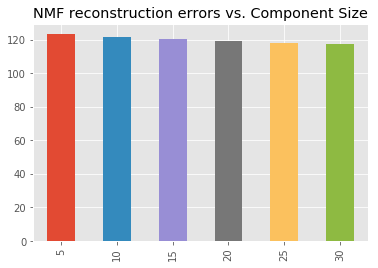

In [7]:
%%time

def plot_errors(texts):
    """Plot the NMF reconstruction error for a range of possible candidate sizes."""
    
    n_range = range(5, 35, 5)
    errors = {n: vsm_representation(n, texts, return_error=True) for n in n_range}
    s = pd.Series(errors, name='NMF reconstruction errors').sort_index()
    ax = s.plot(kind='bar', title='NMF reconstruction errors vs. Component Size')
    return s
    
errors = plot_errors(raw_input.text)
errors.to_csv('nmf_rec_errors.csv')

Based on the plot above, I chose the component size as 20.

In [8]:
vsm_mat = vsm_representation(20, raw_input.text)
vsm_mat.shape

(16000, 20)

Next we visualize our vsm representation by mapping our vsm_matrix into a 2D matrix using t-SNE method.

CPU times: user 14min 46s, sys: 29.6 s, total: 15min 16s
Wall time: 5min 4s


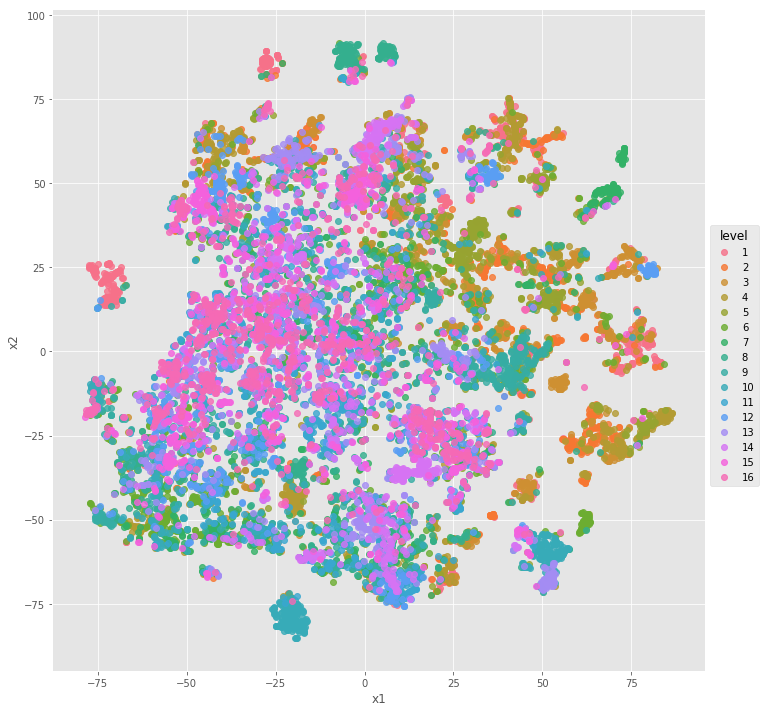

In [9]:
%%time

from sklearn.manifold import TSNE

def plot_2d_representation(tf_mat, levels):
    visualizer = TSNE(n_components=2, perplexity=30.0, random_state=1024)    
    tf_vis = visualizer.fit_transform(tf_mat)
    
    vis_df = pd.DataFrame(data=tf_vis, index=raw_input.index, columns=['x1', 'x2'])
    
    # attach the ground truth labels so that we can assign a different colour to each label.
    vis_df = vis_df.assign(level=levels)
    _ = sns.lmplot(x='x1', y='x2', hue='level', data=vis_df, fit_reg=False, size=10, aspect=1)
    
plot_2d_representation(vsm_mat, raw_input.level)

# K-Means Cluster and Optimal Cluster Size

Next we build another helper function to fit a KMeans cluster on the vector space rerpesentation of our text documents.

In [10]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = np.arange(5, 50)

intertias = []

def cluster_vsm(n_clusters, vsm, batch_size=5000, return_labels=True): 
    """
    Cluster the document VSM using ``MiniBatchKMeans``. 
    
    If `return_labels` is True, return the cluster membership of each row. 
    Otherwise return the `inertia_` attribute, which is a measure of 
    sum of squared errors of each sample relative to the cluster mean.
    """

    clusterer = MiniBatchKMeans(
        n_clusters=n_clusters, 
        compute_labels=True, 
        random_state=1234,
        batch_size=batch_size, 
        tol=1E-3)
    
    clusterer = clusterer.fit(vsm)
    
    if return_labels:
        return clusterer.labels_.copy()
    else:
        return clusterer.inertia_
    


Next, we calculate and plot the `inertia` of the cluster for a range of candidate values for the cluster size.

CPU times: user 17.8 s, sys: 260 ms, total: 18.1 s
Wall time: 2.27 s


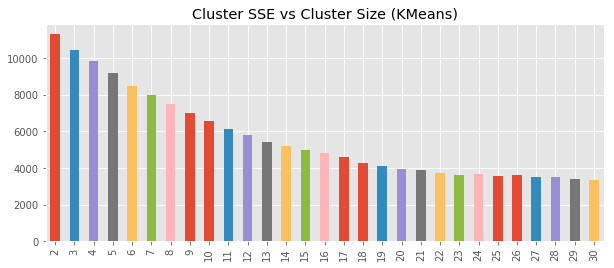

In [11]:
%%time

def calc_cluster_sse(vsm):
    """
    Plot the SSE vs cluster size for a number of candidate cluster sizes.
    """
    n_clusters = range(2, 31)
    errors = {n: cluster_vsm(n, vsm, return_labels=False) for n in n_clusters}
    s = pd.Series(errors, name='elbow_plot').sort_index()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax = s.plot(kind='bar', title='Cluster SSE vs Cluster Size (KMeans)', ax=ax)
    return s
    
cluster_sse = calc_cluster_sse(vsm_mat)
cluster_sse.to_csv('kmeans_sse.csv')

Based on the above, I chose 20 as the optimal cluster size.

# Compare Cluster Assignments with Ground Truth Labels

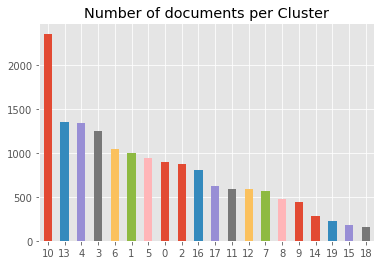

In [12]:
# Extract the cluster assignments assuming 20 clusters
cluster_labels = cluster_vsm(20, vsm_mat)

# Convert to a Series
cluster_labels = pd.Series(index=raw_input.index, data=cluster_labels, name='cluster_labels')

# Plot Count of Labels
label_counts = cluster_labels.value_counts()
label_counts.to_csv('label_counts_small.csv')

ax =label_counts.plot(kind='bar', rot='0', title='Number of documents per Cluster')

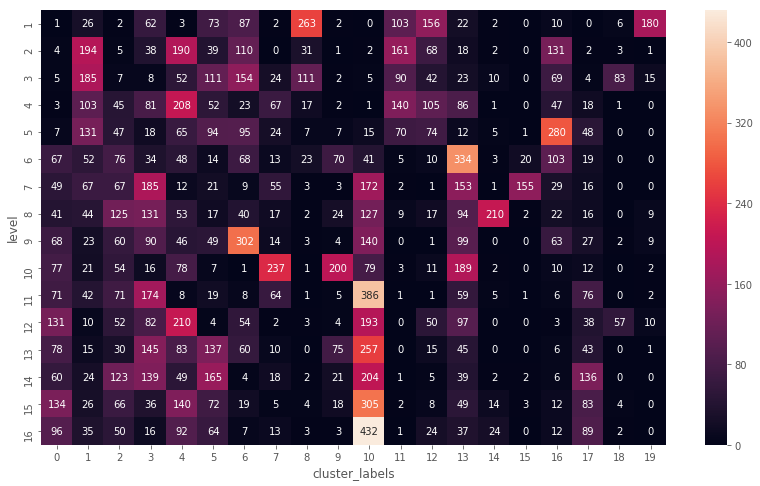

In [13]:
# Cross-tabulate the assigned levels with cluster assignments
ct = pd.crosstab(cluster_labels, raw_input.level).T
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax = sns.heatmap(ct, annot=True, fmt='d', ax=ax)

ct.to_csv('cluster_assignment_vs_labels_small.csv')

Next we calculate the Adjusted Rand Score between the cluster assignments and the ground truth labels, which is a measure of how similar these two label assignments are. 

In [14]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(cluster_labels, raw_input.level)

0.07410982720954486

The adjusted rand score is close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 if they are identical. So this clustering doesn't seem to correspond to the ground truth labels.

In [15]:
from sklearn.manifold import TSNE

def plot_2d_representation(tf_mat):
    visualizer = TSNE(n_components=2, perplexity=30.0, random_state=1024)
    tf_vis = visualizer.fit_transform(tf_mat)
    vis_df = pd.DataFrame(data=tf_vis, index=raw_input.index, columns=['x1', 'x2'])
    vis_df = vis_df.assign(level=raw_input.level)
    _ = sns.lmplot(x='x1', y='x2', hue='level', data=vis_df, fit_reg=False, size=10, aspect=1)